# Motivation


---

In a world where we're constantly chatting, texting, and connecting, imagine the heartbreak of not being able to say a simple "hello." For those with paralysis, especially due to conditions like amyotrophic lateral sclerosis (ALS), speaking can become a distant dream. The ways they once communicated can become frustratingly slow or out of reach altogether.

Brain-computer interfaces (BCIs) designed for speech emerge as a promising solution to this challenge. These BCIs aim to translate the neural activity, stimulated by the attempt of speech, directly into comprehensible text or sound.

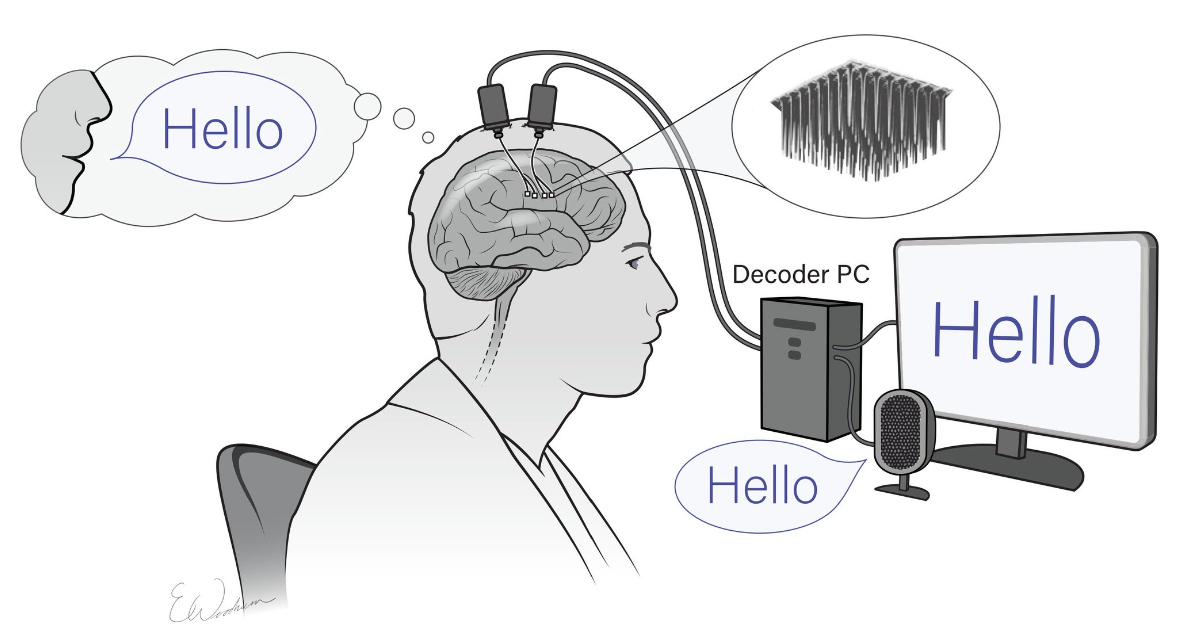

# Experimental Design:


---


- Data originated from instructed delay experiments featuring text-based cues.
- During each trial, the participant (T12) was presented with a red square displaying text, indicating the movement or speech task to attempt.
- Upon the square turning green, the participant executed the described movement.
- Trials are concluded with a 1-second "return" period, allowing T12 to revert to a neutral posture.
- The experiments were conducted with T12 seated, facing a computer monitor displaying the cues.Data collection occurred in blocks, each containing two repetitions of every condition. Breaks were given to T12 between these blocks, with no neural data recorded during these intervals.

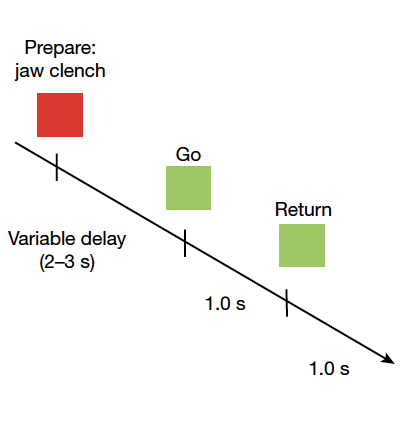

# Load Data


---


- **Phenomes data:** Study participant attempted to **speak single phonemes** in response to cues shown on a computer monitor.
- **orofacial data:** Study participant attempted to **make individual orofacial movements** in response to cues shown on a computer monitor.
- **fiftyWord data:** Study participant attempted to **speak single words** in response to cues shown on a computer monitor.

In [1]:
# import libraries

import scipy.io
import numpy as np
import scipy.stats
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
# @title Download data from Google Drive
# !pip install gdown
!gdown --folder https://drive.google.com/drive/folders/10Ti08QzmeTCpZ0QXaquG9RD0caRKVQnF?usp=sharing -O "../Datasets/willet_speech"


Retrieving folder contents
Processing file 16wpfZd7lnUxvmrjPwO4JKPA4pqON37qV t12.2022.04.21_orofacial.mat
Processing file 1b8UBz4KzCgZ0-Nx1xIhxZjVCISo1cMfw t12.2022.04.21_phonemes.mat
Processing file 11V147ZFE5usLZeT61vNwT129eG00-Crg t12.2022.04.26_phonemes.mat
Processing file 1_TGweavxK79vARWSkmKVh9yoDjxV6mSu t12.2022.05.03_fiftyWordSet.mat
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=16wpfZd7lnUxvmrjPwO4JKPA4pqON37qV
From (redirected): https://drive.google.com/uc?id=16wpfZd7lnUxvmrjPwO4JKPA4pqON37qV&confirm=t&uuid=df61a606-bb39-455e-a290-c16f95849f1b
To: /home/riopar/Documents/hackathon/EFRI-workshop-2023/Datasets/willet_speech/t12.2022.04.21_orofacial.mat
100%|████████████████████████████████████████| 157M/157M [00:05<00:00, 29.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1b8UBz4KzCgZ0-Nx1xIhxZjVCISo1cMfw
From (redirected): https://drive

In [7]:
baseDir = "../Datasets/willet_speech/"

## Data Structure

The dataset provides
-  Spike power band termed spikePow: timeBin x nChan representation of binned spike band power with 20 ms bins.
    - T: timeBin: Represents the number of time steps
    - F: nChan: Represents the number of channels, which is 256 in total
- Neural spike train termed tx2: timeBin x nChan matrix of binned threshold crossing counts (20 ms bins). The data was denoised with a linear regression reference technique and a -4.5 x RMS threshold was used.

In [8]:

subtractMeansWithinBlock = False

phonemesDat = scipy.io.loadmat(baseDir+'t12.2022.04.21_phonemes.mat')
orofacialDat = scipy.io.loadmat(baseDir+'t12.2022.04.21_orofacial.mat')
fiftyWordDat = scipy.io.loadmat(baseDir+'t12.2022.05.03_fiftyWordSet.mat')

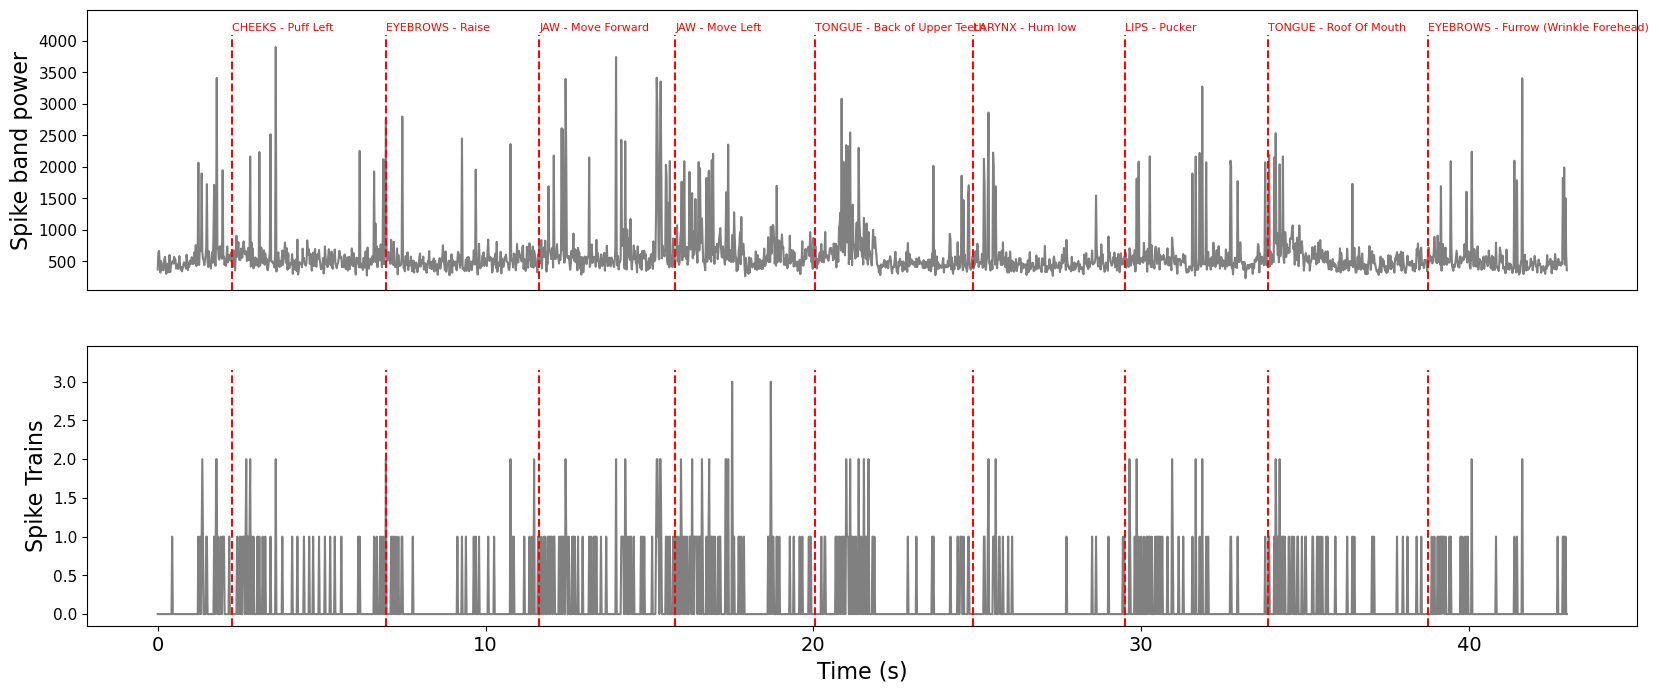

In [9]:
#
channelIdx = 69
timeframe_max = 2150
timeScale = np.arange(timeframe_max)*0.02
plt.figure(figsize=(20,4*2))
plt.subplot(2,1,1)
plt.plot(timeScale,orofacialDat["spikePow"][:timeframe_max,channelIdx],'gray')
xlimits = plt.xlim()
ylimits = plt.ylim()
eventIdx = np.where(orofacialDat["goTrialEpochs"][:,0]<timeframe_max)[0]
eventTimes = timeScale[orofacialDat["goTrialEpochs"][eventIdx,0].astype(int)]
plt.vlines(eventTimes,ylimits[0],ylimits[1],color='r',linestyles='--')
taskNames = orofacialDat["cueList"][0,orofacialDat["trialCues"][eventIdx]-1].flatten()
for eventIdx in range(len(eventTimes)):
  plt.text(eventTimes[eventIdx],ylimits[1]*1.02,taskNames[eventIdx][0],fontsize=8,color='r')
plt.xlim(xlimits)
plt.ylim([ylimits[0],ylimits[1]*1.1])
plt.ylabel("Spike band power",fontsize=16)

plt.xticks([],fontsize=14)
plt.yticks(fontsize=11)

plt.subplot(2,1,2)
plt.plot(timeScale,orofacialDat["tx2"][:timeframe_max,channelIdx],'gray')
xlimits = plt.xlim()
ylimits = plt.ylim()
eventIdx = np.where(orofacialDat["goTrialEpochs"][:,0]<timeframe_max)[0]
eventTimes = timeScale[orofacialDat["goTrialEpochs"][eventIdx,0].astype(int)]
plt.vlines(eventTimes,ylimits[0],ylimits[1],color='r',linestyles='--')
taskNames = orofacialDat["cueList"][0,orofacialDat["trialCues"][eventIdx]-1].flatten()
# for eventIdx in range(len(eventTimes)):
#   plt.text(eventTimes[eventIdx],ylimits[1]*1.02,taskNames[eventIdx][0],fontsize=8,color='r')
plt.xlim(xlimits)
plt.ylim([ylimits[0],ylimits[1]*1.1])
plt.ylabel("Spike Trains",fontsize=16)
plt.xlabel("Time (s)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=11)
plt.show()

## helper functions

In [10]:
def meanResamples(trlConcat, nResamples):
    resampleMeans = np.zeros((nResamples, trlConcat.shape[1], trlConcat.shape[2]))
    for rIdx in range(nResamples):
        resampleIdx = np.random.randint(0,trlConcat.shape[0],trlConcat.shape[0])
        resampleTrl = trlConcat[resampleIdx,:,:]
        resampleMeans[rIdx,:,:] = np.sum(resampleTrl, axis=0)/trlConcat.shape[0]

    return resampleMeans

def triggeredAvg(features, eventIdx, eventCodes, window, smoothSD=0, computeCI=True, nResamples=100):
    winLen = window[1]-window[0]
    codeList = np.unique(eventCodes)

    featAvg = np.zeros([len(codeList), winLen, features.shape[1]])
    featCI = np.zeros([len(codeList), winLen, features.shape[1], 2])
    allTrials = []

    for codeIdx in range(len(codeList)):
        trlIdx = np.squeeze(np.argwhere(eventCodes==codeList[codeIdx]))
        trlSnippets = []
        for t in trlIdx:
            if (eventIdx[t]+window[0])<0 or (eventIdx[t]+window[1])>=features.shape[0]:
                continue
            trlSnippets.append(features[(eventIdx[t]+window[0]):(eventIdx[t]+window[1]),:])

        trlConcat = np.stack(trlSnippets,axis=0)
        allTrials.append(trlConcat)

        if smoothSD>0:
            trlConcat = gaussian_filter1d(trlConcat, smoothSD, axis=1)

        featAvg[codeIdx,:,:] = np.mean(trlConcat, axis=0)

        if computeCI:
            tmp = np.percentile(meanResamples(trlConcat, nResamples), [2.5, 97.5], axis=0)
            featCI[codeIdx,:,:,:] = np.transpose(tmp,[1,2,0])

    return featAvg, featCI, allTrials

# Define function to plot spike raster
def plot_spike_raster(data, ax, s=7, fontsize=20):
    """
    Function to plot spike raster.

    Parameters:
    - data: The data array to plot
    - ax: Axes on which to plot
    - s: size of the scatter markers
    - fontsize: fontsize for labels and titles (unused in current function but can be integrated if required)
    """
    data_array = copy.deepcopy(data)
    data_array = data_array.astype(float)
    n_y, n_t = data_array.shape

    row = np.ones(n_t)
    t = np.arange(n_t)
    col = np.arange(n_y)

    frame = col[:, np.newaxis] + row[np.newaxis, :]
    data_array[data_array == 0] = np.nan

    raster = ax.scatter(t * data_array, frame * data_array, marker='|', facecolor='black', s=s, rasterized=False)
    ax.set_xlim([0, n_t])
    ax.xaxis.set_visible(False)
    ax.set_yticks([])

def plotPreamble():
    import matplotlib.pyplot as plt

    SMALL_SIZE=5
    MEDIUM_SIZE=6
    BIGGER_SIZE=7

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.rcParams['svg.fonttype'] = 'none'


#gaussian naive bayes classifier with variable time window and channel set
def gnb_loo(trials_input, timeWindow, chanIdx):
    unroll_Feat = []
    for t in range(len(trials_input)):
        for x in range(trials_input[t].shape[0]):
            unroll_Feat.append(trials_input[t][x,:,:])

    unroll_Feat = np.concatenate(unroll_Feat, axis=0)
    mn = np.mean(unroll_Feat, axis=0)
    sd = np.std(unroll_Feat, axis=0)

    unroll_X = []
    unroll_y = []

    for t in range(len(trials_input)):
        for x in range(trials_input[t].shape[0]):
            tmp = (trials_input[t][x,:,:] - mn[np.newaxis,:])/sd[np.newaxis,:]
            b1 = np.mean(tmp[timeWindow[0]:timeWindow[1],chanIdx], axis=0)

            unroll_X.append(np.concatenate([b1]))
            unroll_y.append(t)

    unroll_X = np.stack(unroll_X, axis=0)
    unroll_y = np.array(unroll_y).astype(np.int32)

    from sklearn.naive_bayes import GaussianNB

    y_pred = np.zeros([unroll_X.shape[0]])
    for t in range(unroll_X.shape[0]):
        X_train = np.concatenate([unroll_X[0:t,:], unroll_X[(t+1):,:]], axis=0)
        y_train = np.concatenate([unroll_y[0:t], unroll_y[(t+1):]])

        gnb = GaussianNB()
        gnb.fit(X_train, y_train)
        gnb.var_ = np.ones(gnb.var_.shape)*np.mean(gnb.var_)

        pred_val = gnb.predict(unroll_X[np.newaxis,t,:])
        y_pred[t] = pred_val[0]

    return y_pred, unroll_y

def bootCI(x,y):
    nReps = 10000
    bootAcc = np.zeros([nReps])
    for n in range(nReps):
        shuffIdx = np.random.randint(len(x),size=len(x))
        bootAcc[n] = np.mean(x[shuffIdx]==y[shuffIdx])

    return np.percentile(bootAcc,[2.5, 97.5])

def plotConfusionMatrix(unroll_y, y_pred, tickLabels, orderIdx, title, figName):
    #confusion matrices
    codeList = np.unique(unroll_y)
    nCodes = len(codeList)
    cMat = np.zeros([nCodes, nCodes])

    for x in range(nCodes):
        for y in range(nCodes):
            thisSum = np.sum(np.logical_and(unroll_y==codeList[orderIdx[x]], y_pred==codeList[orderIdx[y]]))
            cMat[x,y] = thisSum

    for x in range(nCodes):
        cMat[x,:] = cMat[x,:] / np.sum(cMat[x,:])



    plotPreamble()

    plt.figure(figsize=(4,4), dpi=300)
    plt.imshow(cMat,clim=[0,1])

    reorderLabels = []
    for x in range(len(tickLabels)):
        reorderLabels.append(tickLabels[orderIdx[x]])

    plt.xticks(ticks=np.arange(0,len(tickLabels)), labels=reorderLabels, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(0,len(tickLabels)), labels=reorderLabels)
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.title(title)

    plt.show()

def makeTuningHeatmap(dat, sets, window):

    features = dat['tx2'].astype(np.float32)
    nFeat = features.shape[1]
    nTrials = dat['goTrialEpochs'].shape[0]
    nClasses = dat['cueList'].shape[1]

    trialVectors = np.zeros([nTrials, features.shape[1]])
    predVectors = np.zeros([nTrials, features.shape[1]])

    tuningR2 = np.zeros([nFeat, len(sets)])
    tuningPVal = np.zeros([nFeat, len(sets)])

    for t in range(nTrials):
        trialVectors[t,:] = np.mean(features[(dat['goTrialEpochs'][t,0]+window[0]):(dat['goTrialEpochs'][t,0]+window[1])], axis=0)

    #split observations into folds
    nFolds = 5
    heldOutIdx = []
    minPerFold = np.floor(trialVectors.shape[0]/nFolds).astype(np.int32)
    remainder = trialVectors.shape[0]-minPerFold*nFolds
    if remainder>0:
        currIdx = np.arange(0,(minPerFold+1)).astype(np.int32)
    else:
        currIdx = np.arange(0,minPerFold).astype(np.int32)

    for x in range(nFolds):
        heldOutIdx.append(currIdx.copy())
        currIdx += len(currIdx)
        if remainder!=0 and x==remainder:
            currIdx = currIdx[0:-1]

    for foldIdx in range(nFolds):
        meanVectors = np.zeros([nClasses, nFeat])
        for m in range(nClasses):
            trlIdx = np.squeeze(np.argwhere(np.squeeze(dat['trialCues']-1)==m))
            trlIdx = np.setdiff1d(trlIdx, heldOutIdx[foldIdx])
            meanVectors[m,:] = np.mean(trialVectors[trlIdx,:], axis=0)

        for t in heldOutIdx[foldIdx]:
            predVectors[t,:] = meanVectors[dat['trialCues'][t,0]-1,:]

    for setIdx in range(len(sets)):
        mSet = sets[setIdx]
        trlIdx = np.argwhere(np.in1d(np.squeeze(dat['trialCues']-1), mSet))
        SSTOT = np.sum(np.square(trialVectors[trlIdx,:]-np.mean(trialVectors[trlIdx,:],axis=0,keepdims=True)), axis=0)
        SSERR = np.sum(np.square(trialVectors[trlIdx,:]-predVectors[trlIdx,:]), axis=0)

        tuningR2[:,setIdx] = 1-SSERR/SSTOT

        groupVectors = []
        for m in mSet:
            trlIdx = np.argwhere(np.squeeze(dat['trialCues']-1)==m)
            groupVectors.append(trialVectors[trlIdx,:])

        fResults = scipy.stats.f_oneway(*groupVectors,axis=0)
        tuningPVal[:,setIdx] = fResults[1]

    return tuningR2, tuningPVal


def heatmapPlotCircles(tuning, isSig, clim, titles, layout):
    circle_cmap = cm.Blues(np.linspace(0,1,256))
    nPlots = tuning.shape[1]
    if layout=='6v':
        arrRows = [np.arange(64,128).astype(np.int32), np.arange(0,64).astype(np.int32)]
    elif layout=='ifg':
        arrRows = [np.flip(np.arange(64,128).astype(np.int32)), np.flip(np.arange(0,64).astype(np.int32))]

    plt.figure(figsize=(nPlots*0.8,2*0.8), dpi=300)
    for plotIdx in range(nPlots):
        for arrIdx in range(len(arrRows)):
            plt.subplot(2,nPlots,1+plotIdx+arrIdx*nPlots)

            matVals = tuning[arrRows[arrIdx], plotIdx]
            mat = np.reshape(matVals, [8,8], 'F')

            matVals_sig = isSig[arrRows[arrIdx], plotIdx]
            mat_sig = np.reshape(matVals_sig, [8,8], 'F')

            for x in range(8):
                for y in range(8):
                    if mat_sig[y,x]:
                        thisColor = np.round(255*mat[y,x]/clim[1]).astype(np.int32)
                        if thisColor>255:
                            thisColor = 255
                        if thisColor<0:
                            thisColor = 0

                        plt.plot(x,-y,'o',color=circle_cmap[thisColor,:],markersize=4,markeredgecolor ='k',markeredgewidth=0.1)
                    else:
                        plt.plot(x,-y,'x',color='k',markersize=1,alpha=0.1)

            plt.gca().set_xticks([])
            plt.gca().set_yticks([])

            ax = plt.gca()
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(0.75)

            if arrIdx==0:
                plt.title(titles[plotIdx],fontsize=6)



In [11]:
#option to mean-subtract within block

def meanSubtract_binnedTX(dat):
    dat['binnedTX'] = dat['binnedTX'].astype(np.float32)
    blockList = np.squeeze(np.unique(dat['blockNum']))
    for b in blockList:
        loopIdx = np.squeeze(dat['blockNum']==b)
        dat['binnedTX'][loopIdx,:] -= np.mean(dat['binnedTX'][loopIdx,:],axis=0,keepdims=True)
    return dat

#mean subtraction
if subtractMeansWithinBlock:
    phonemesDat = meanSubtract_binnedTX(phonemesDat)
    orofacialDat = meanSubtract_binnedTX(orofacialDat)
    fiftyWordDat = meanSubtract_binnedTX(fiftyWordDat)

In [12]:
#get triggered averages for making PSTHs
fAvg_phones, fCI_phones, trials_phones = triggeredAvg(phonemesDat['tx2'].astype(np.float32),
                         phonemesDat['goTrialEpochs'][:,0],
                         np.squeeze(phonemesDat['trialCues']), [-100,100], smoothSD=4)

In [13]:
fAvg_orofacial, fCI_orofacial, trials_orofacial = triggeredAvg(orofacialDat['tx2'].astype(np.float32),
                         orofacialDat['goTrialEpochs'][:,0],
                         np.squeeze(orofacialDat['trialCues']), [-100,100], smoothSD=4)

In [14]:
fAvg_fiftyWord, fCI_fiftyWord, trials_fiftyWord = triggeredAvg(fiftyWordDat['tx2'].astype(np.float32),
                         fiftyWordDat['goTrialEpochs'][:,0],
                         np.squeeze(fiftyWordDat['trialCues']), [-100,100], smoothSD=4)

# Data Visualization

In [15]:
#define the conditions that go into each PSTH panel
eyebrowSet = [5,6,7,8]
eyeSet = [9,10,11,12]
jawSet = [13,14,17,18]
larynxSet = [19,20,21,22]
lipsSet = [23,24,27,28]
tongueSet = [29,30,31,32]
orofacialSets = [eyebrowSet, eyeSet, jawSet, lipsSet, tongueSet, larynxSet]
phonemeSet = [0,5,30,39]
fiftyWordSet = [4,7,20,31]

setTitles = ['Forehead','Eyelids','Jaw','Lips','Tongue','Larynx','Phonemes','Words']

channelIdx = 69
timeAxis = np.arange(-100,100)*0.02

legends = [['Furrow','Raise','Raise Left','Raise Right'],
       ['Close','Open Wide','Wink Left','Wink Right'],
       ['Jaw Clench','Jaw Drop','Jaw Left','Jaw Right'],
       ['Frown','Pucker','Smile','Tuck'],
       ['Tongue Down','Tongue Up','Tongue Left','Tongue Right'],
       ['Hum High','Hum Loud','Hum Low','Hum Soft'],
       ['B','G','IH','AE'],
       ['Bring','Comfortable','Help','Need']]

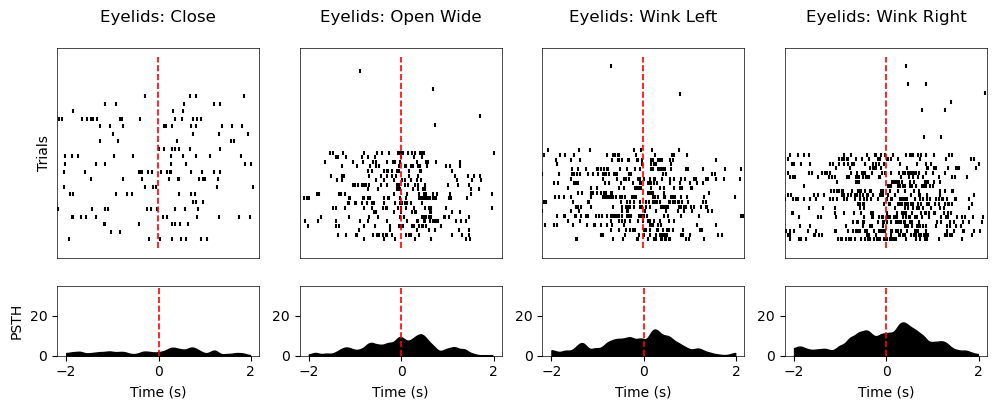

In [16]:
import matplotlib.pyplot as plt
import copy
import numpy as np

# Set the title of the orofacial set
set_title = 'Eyelids' # you can play around with this from the following set: {'Forehead','Eyelids','Jaw','Lips','Tongue','Larynx'}
set_titles_list = setTitles  # Assuming setTitles is defined somewhere earlier
index_of_title = set_titles_list.index(set_title)

# Indexes for trials
first_trial_index = orofacialSets[index_of_title][0]
second_trial_index = orofacialSets[index_of_title][3]

first_title_name = legends[index_of_title][0]
second_title_name = legends[index_of_title][3]

# Define y-axis limits based on data normalization
if subtractMeansWithinBlock:
    y_axis_limits = [-10, 25]
else:
    y_axis_limits = [0, 35]

# Index for the channel
channel_index = 69

# Create figure and axes for plotting
fig, ax = plt.subplots(2, 4, figsize=(12, 4), gridspec_kw={'height_ratios': [3, 1]})


for trial_index in range(4):
    # Plotting spike raster for the first trial
    idx = orofacialSets[index_of_title][trial_index]
    plot_spike_raster(trials_orofacial[idx][:, :, channel_index], ax[0, trial_index])

    # Plotting average traces for both trials
    avg_trace_first_trial = 50 * fAvg_orofacial[idx, :, channel_index]
    ax[1, trial_index].fill_between(timeAxis, np.zeros(avg_trace_first_trial.shape), avg_trace_first_trial, linewidth=1, color='k')

    # Setting labels and titles
    ax[0, trial_index].set_title("{}: {}\n".format(set_title,legends[index_of_title][trial_index]))
    ax[1, trial_index].set_xlabel('Time (s)')
    ax[1, 0].set_ylabel("PSTH")
    ax[0, 0].set_ylabel("Trials")

    ax[1, trial_index].set_ylim(y_axis_limits)


# Adjusting plot visuals
for subplot in [ax[0, 0], ax[0, 1],ax[0, 2], ax[0, 3]]:
    subplot.plot([100, 100], subplot.get_ylim(), '--r', linewidth=1.2)
    for axis in ['top', 'bottom', 'left', 'right']:
        subplot.spines[axis].set_linewidth(0.5)
for subplot in [ax[1, 0], ax[1, 1],ax[1, 2], ax[1, 3]]:
    subplot.plot([0, 0], subplot.get_ylim(), '--r', linewidth=1.2)
    for axis in ['top', 'bottom', 'left', 'right']:
        subplot.spines[axis].set_linewidth(0.5)


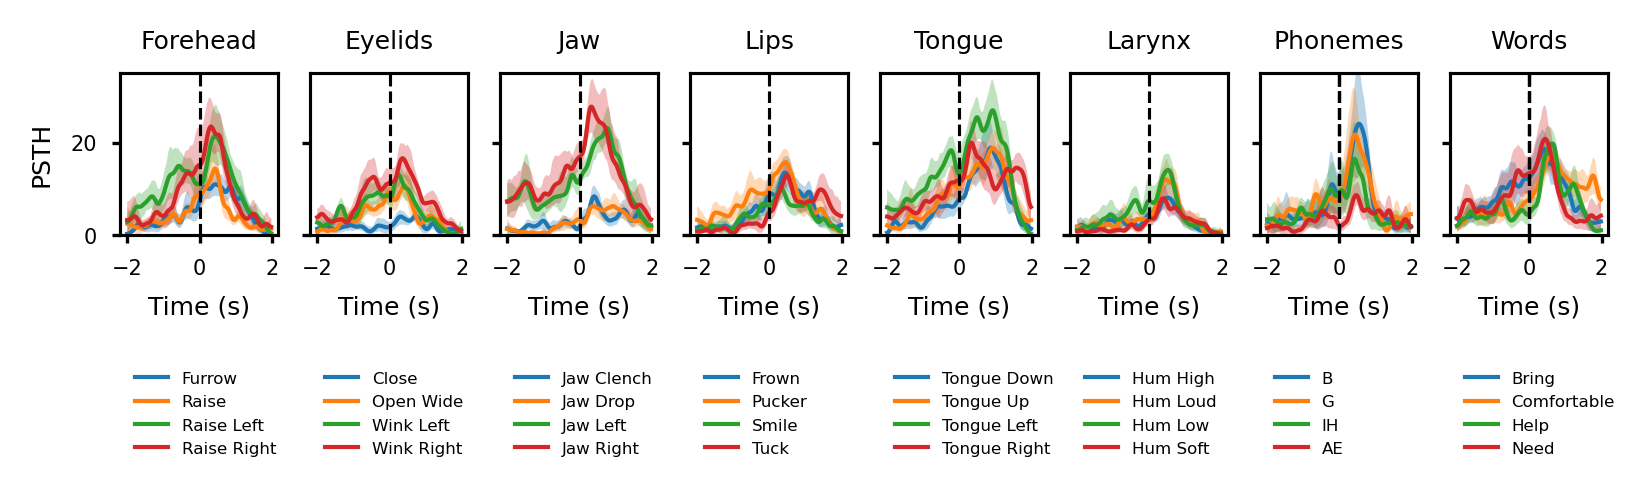

In [17]:
#plot the PSTH for the channel specified by channelIdx
import matplotlib.pyplot as plt
# from analysis import plotPreamble

plotPreamble()

if subtractMeansWithinBlock:
    yLimit = [-10,25]
else:
    yLimit = [0,35]

plt.figure(figsize=(len(setTitles)*(4/5),0.7), dpi=300)
for setIdx in range(len(orofacialSets)):
    conIdx = orofacialSets[setIdx]
    plt.subplot(1,len(orofacialSets)+2,setIdx+1)
    lines = []
    for c in range(len(conIdx)):
        tmp = plt.plot(timeAxis, 50*fAvg_orofacial[conIdx[c], :, channelIdx],linewidth=1)
        lines.append(tmp[0])
        plt.fill_between(timeAxis,
                         50*fCI_orofacial[conIdx[c], :, channelIdx,0],
                         50*fCI_orofacial[conIdx[c], :, channelIdx,1],alpha=0.3)
    plt.ylim(yLimit)
    plt.plot([0,0],plt.gca().get_ylim(),'--k',linewidth=0.75)
    if setIdx>0:
        plt.gca().set_yticklabels([])
    else:
        if subtractMeansWithinBlock:
            plt.ylabel('Δ PSTH')
        else:
            plt.ylabel('PSTH')

    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.75)
    ax.tick_params(length=2)

    plt.xlabel('Time (s)')
    plt.title(setTitles[setIdx])
    plt.legend(lines,legends[setIdx],loc='upper left', bbox_to_anchor=(0.0, -0.75),fontsize=4,frameon=False)
    #plt.xlim([-0.5,1.0])

plt.subplot(1,len(orofacialSets)+2,len(orofacialSets)+1)
conIdx = phonemeSet
for c in range(len(conIdx)):
    plt.plot(timeAxis, 50*fAvg_phones[conIdx[c], :, channelIdx],linewidth=1)
    plt.fill_between(timeAxis,
                 50*fCI_phones[conIdx[c], :, channelIdx,0],
                 50*fCI_phones[conIdx[c], :, channelIdx,1],alpha=0.3)
    plt.ylim(yLimit)
    plt.plot([0,0],plt.gca().get_ylim(),'--k',linewidth=0.75)
    plt.title(setTitles[-2])
    plt.gca().set_yticklabels([])
    plt.xlabel('Time (s)')
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.75)
    ax.tick_params(length=2)
    plt.legend(lines,legends[-2],loc='upper left', bbox_to_anchor=(0.0, -0.75),fontsize=4,frameon=False)

plt.subplot(1,len(orofacialSets)+2,len(orofacialSets)+2)
conIdx = fiftyWordSet
for c in range(len(conIdx)):
    plt.plot(timeAxis, 50*fAvg_fiftyWord[conIdx[c], :, channelIdx],linewidth=1)
    plt.fill_between(timeAxis,
                 50*fCI_fiftyWord[conIdx[c], :, channelIdx,0],
                 50*fCI_fiftyWord[conIdx[c], :, channelIdx,1],alpha=0.3)
    plt.ylim(yLimit)
    plt.plot([0,0],plt.gca().get_ylim(),'--k',linewidth=0.75)
    plt.title(setTitles[-1])
    plt.gca().set_yticklabels([])
    plt.xlabel('Time (s)')
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.75)
    ax.tick_params(length=2)
    plt.legend(lines,legends[-1],loc='upper left', bbox_to_anchor=(0.0, -0.75),fontsize=4,frameon=False)

plt.show()

# Naive Bayes Classification

In [18]:
#classify amongst all conditions EXCEPT "do nothing"
phonemeCuesToUse = np.array([0,1,3,4,5,6,7,8,9,10,11,12,14,15,16,17,19,20,21,22,23,24,
                      26,27,28,29,30,31,32,33,34,35,36,37,38,39]).astype(np.int32)
oroCuesToUse = np.array([0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                         21,22,23,24,25,26,27,28,29,30,31,32,33]).astype(np.int32)
fiftyWordCuesToUse = np.arange(1,51).astype(np.int32)

In [19]:
brainArea='6v'

def meanSubtract(dat):
    if brainArea=='6v':
        dat['feat'] = np.concatenate([dat['tx2'][:,0:128].astype(np.float32), dat['spikePow'][:,0:128].astype(np.float32)], axis=1)
    elif brainArea=='44':
        dat['feat'] = np.concatenate([dat['tx2'][:,128:].astype(np.float32), dat['spikePow'][:,128:].astype(np.float32)], axis=1)

    blockList = np.squeeze(np.unique(dat['blockNum']))
    for b in blockList:
        loopIdx = np.squeeze(dat['blockNum']==b)
        dat['feat'][loopIdx,:] -= np.mean(dat['feat'][loopIdx,:],axis=0,keepdims=True)
    return dat

phonemesDat = meanSubtract(phonemesDat)
orofacialDat = meanSubtract(orofacialDat)
fiftyWordDat = meanSubtract(fiftyWordDat)

fAvg_phones, fCI_phones, trials_phones = triggeredAvg(phonemesDat['feat'].astype(np.float32),
                         phonemesDat['goTrialEpochs'][:,0],
                         np.squeeze(phonemesDat['trialCues']), [-50,50], smoothSD=4)

fAvg_orofacial, fCI_orofacial, trials_orofacial = triggeredAvg(orofacialDat['feat'].astype(np.float32),
                         orofacialDat['goTrialEpochs'][:,0],
                         np.squeeze(orofacialDat['trialCues']), [-50,50], smoothSD=4)

fAvg_fiftyWord, fCI_fiftyWord, trials_fiftyWord = triggeredAvg(fiftyWordDat['feat'].astype(np.float32),
                         fiftyWordDat['goTrialEpochs'][:,0],
                         np.squeeze(fiftyWordDat['trialCues']), [-50,50], smoothSD=4)

### Classification on phoneme data

In [20]:
trials_phones_subset = []
for t in range(len(phonemeCuesToUse)):
    trials_phones_subset.append(trials_phones[phonemeCuesToUse[t]])

y_pred, unroll_y = gnb_loo(trials_phones_subset, [50,100], np.arange(0,256).astype(np.int32))
acc = np.mean(y_pred==unroll_y)
CI = bootCI(y_pred, unroll_y)
print("Accuracy: {:.2f}".format(acc*100))
print("95% confidence intervals: [{:.2f}, {:.2f}]".format(CI[0]*100,CI[1]*100))

Accuracy: 61.46
95% confidence intervals: [57.47, 65.45]


### Confusion Matrix

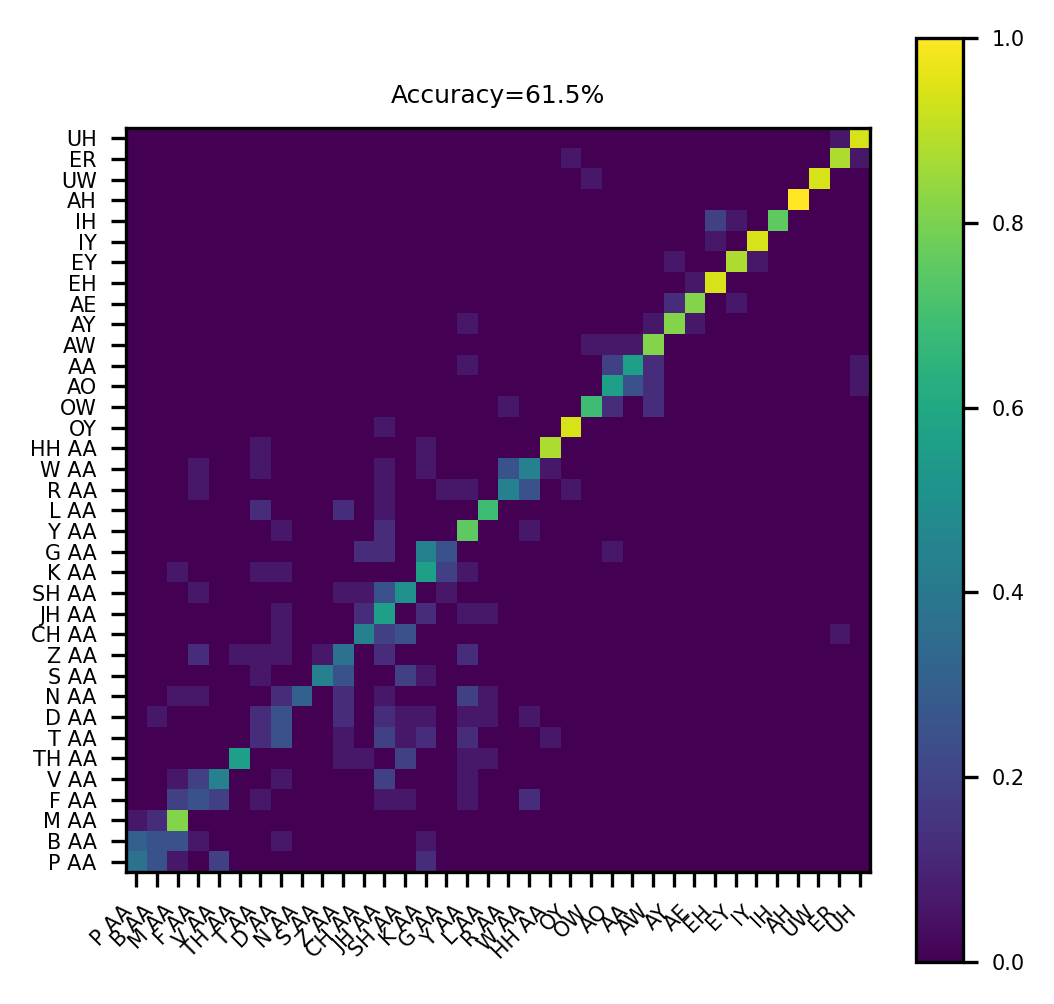

In [21]:
tickLabels = ['B AA','CH AA','D AA','F AA',
             'G AA','HH AA','JH AA','K AA',
             'L AA','ER','M AA','N AA',
             'P AA','R AA','S AA','SH AA','T AA','TH AA',
             'V AA','W AA','Y AA','Z AA',
             'OY','EH','EY','UH','IY','OW',
             'UW','IH','AA','AW','AY','AH','AO','AE']

tickLabelsReorder = ['P AA','B AA','M AA','F AA',
             'V AA','TH AA','T AA','D AA',
             'N AA','S AA','Z AA','CH AA',
             'JH AA','SH AA','K AA','G AA','Y AA','L AA',
             'R AA','W AA','HH AA','OY','OW',
             'AO','AA','AW','AY','AE','EH',
             'EY','IY','IH','AH','UW','ER','UH']

orderIdx = []
for x in range(len(tickLabelsReorder)):
    for y in range(len(tickLabels)):
        if tickLabels[y]==tickLabelsReorder[x]:
            orderIdx.append(y)
            break

orderIdx = np.array(orderIdx).astype(np.int32)
plotConfusionMatrix(unroll_y, y_pred, tickLabels, orderIdx,
                    'Accuracy='+str(np.round(1000*np.mean(y_pred==unroll_y))/10)+'%',
                    'phonemeConfusionMatrix_'+brainArea)

### Classification on orofacial data

In [22]:
trials_orofacial_subset = []
for t in range(len(oroCuesToUse)):
    trials_orofacial_subset.append(trials_orofacial[oroCuesToUse[t]])

y_pred, unroll_y = gnb_loo(trials_orofacial_subset, [50,100], np.arange(0,256).astype(np.int32))
acc = np.mean(y_pred==unroll_y)
CI = bootCI(y_pred, unroll_y)
print("Accuracy: {:.2f}".format(acc*100))
print("95% confidence intervals: [{:.2f}, {:.2f}]".format(CI[0]*100,CI[1]*100))

Accuracy: 91.21
95% confidence intervals: [89.09, 93.33]


### Confusion Matrix

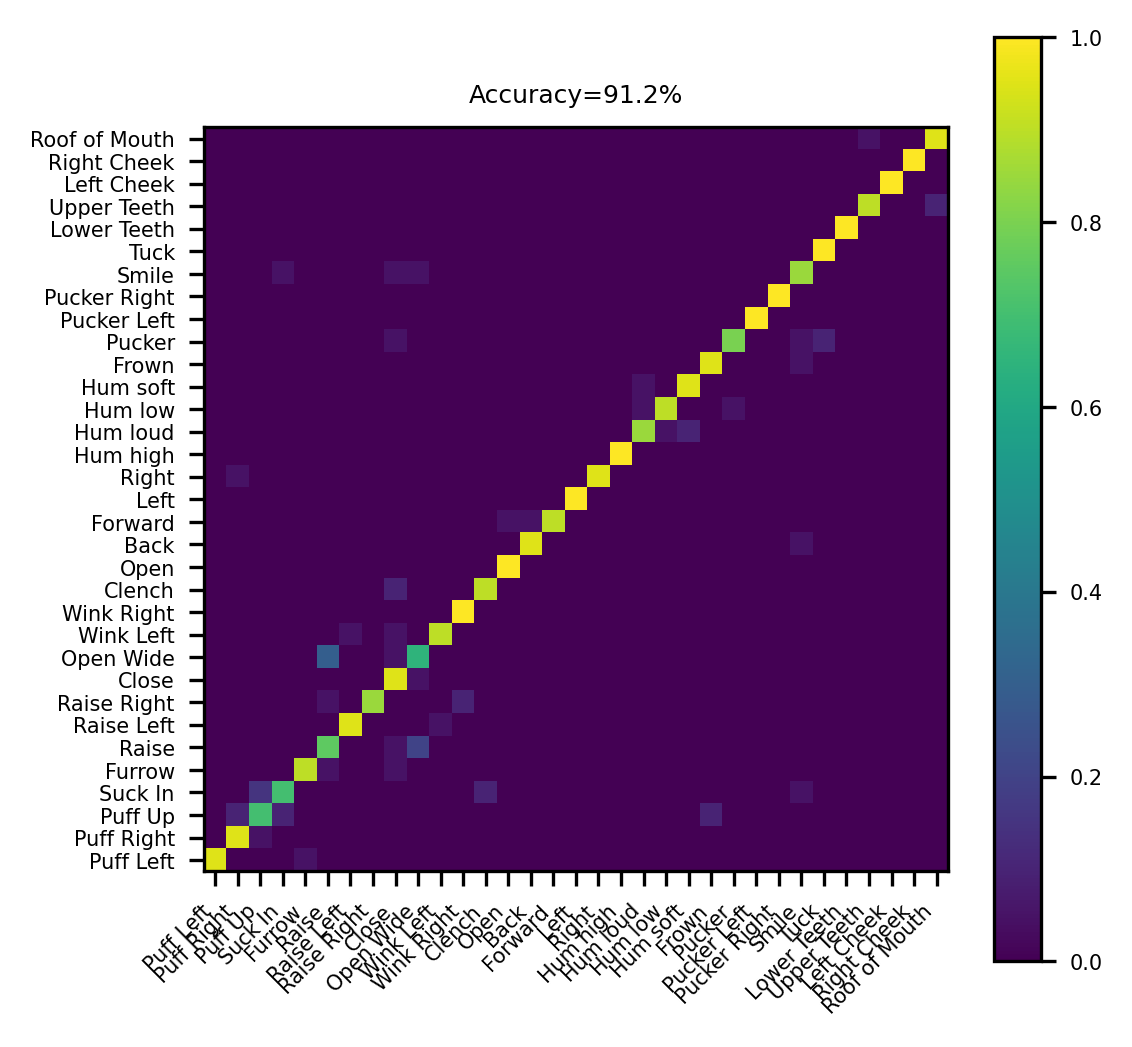

In [23]:
tickLabels = ['Puff Left','Puff Right','Puff Up','Suck In',
                 'Furrow','Raise','Raise Left','Raise Right',
                 'Close','Open Wide','Wink Left','Wink Right',
                 'Clench','Open','Back','Forward','Left','Right',
                 'Hum high','Hum loud','Hum low','Hum soft',
                 'Frown','Pucker','Pucker Left','Pucker Right','Smile','Tuck',
                 'Lower Teeth','Upper Teeth','Left Cheek','Right Cheek','Roof of Mouth']

plotConfusionMatrix(unroll_y, y_pred, tickLabels, np.arange(0,34).astype(np.int32),
                    'Accuracy='+str(np.round(1000*np.mean(y_pred==unroll_y))/10)+'%',
                    'orofacialConfusionMatrix_'+brainArea)

### Classification on fiftyWord data

In [24]:
trials_fiftyWord_subset = []
for t in range(len(fiftyWordCuesToUse)):
    trials_fiftyWord_subset.append(trials_fiftyWord[fiftyWordCuesToUse[t]])

y_pred, unroll_y = gnb_loo(trials_fiftyWord_subset, [50,100], np.arange(0,256).astype(np.int32))
acc = np.mean(y_pred==unroll_y)
CI = bootCI(y_pred, unroll_y)
print("Accuracy: {:.2f}".format(acc*100))
print("95% confidence intervals: [{:.2f}, {:.2f}]".format(CI[0]*100,CI[1]*100))

Accuracy: 94.10
95% confidence intervals: [92.70, 95.50]


### Confusion Matrix

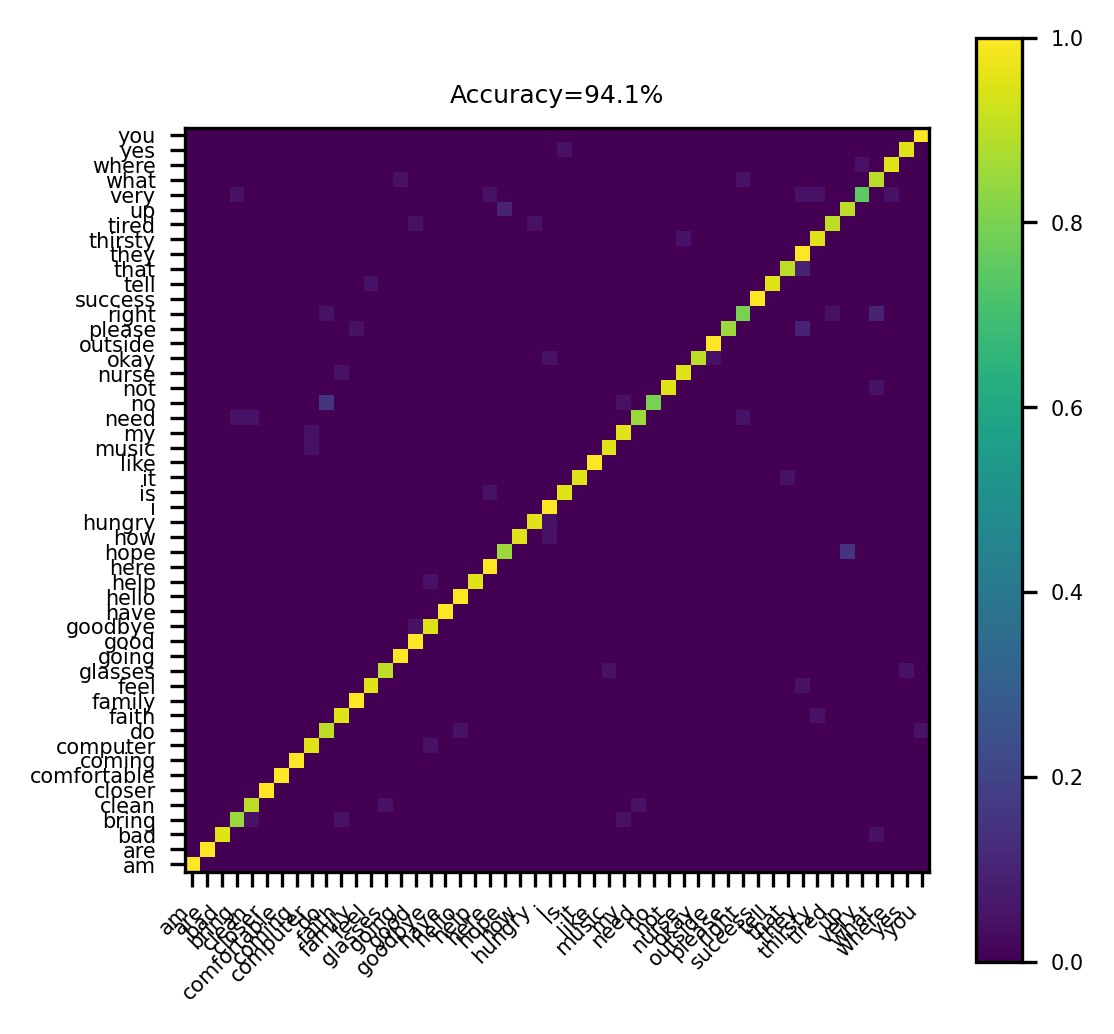

In [25]:
tickLabels = fiftyWordDat['cueList'][0,1:51]
fixedLabels = []
for x in range(len(tickLabels)):
    fixedLabels.append(tickLabels[x][0])

orderIdx = np.arange(0,50).astype(np.int32)
plotConfusionMatrix(unroll_y, y_pred, fixedLabels, orderIdx,
                    'Accuracy='+str(np.round(1000*np.mean(y_pred==unroll_y))/10)+'%',
                    'fiftyWordConfusionMatrix_'+brainArea)

# Tuning heatmaps

In [27]:
def unscrambleChans(timeSeriesDat):
    chanToElec = [63, 64, 62, 61, 59, 58, 60, 54, 57, 50, 53, 49, 52, 45, 55, 44, 56, 39, 51, 43,
                  46, 38, 48, 37, 47, 36, 42, 35, 41, 34, 40, 33, 96, 90, 95, 89, 94, 88, 93, 87,
                  92, 82, 86, 81, 91, 77, 85, 83, 84, 78, 80, 73, 79, 74, 75, 76, 71, 72, 68, 69,
                  66, 70, 65, 67, 128, 120, 127, 119, 126, 118, 125, 117, 124, 116, 123, 115, 122, 114, 121, 113,
                  112, 111, 109, 110, 107, 108, 106, 105, 104, 103, 102, 101, 100, 99, 97, 98, 32, 30, 31, 29,
                  28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 16, 17, 7, 15, 6, 14, 5, 13, 4, 12, 3, 11, 2, 10, 1, 9, 8]
    chanToElec = np.array(chanToElec).astype(np.int32)-1

    unscrambledDat = timeSeriesDat.copy()
    for x in range(len(chanToElec)):
        unscrambledDat[:,chanToElec[x]] = timeSeriesDat[:,x]

    return unscrambledDat

def meanSubtract(dat):
    dat['tx2'] = dat['tx2'].astype(np.float32)
    blockList = np.squeeze(np.unique(dat['blockNum']))
    for b in blockList:
        loopIdx = np.squeeze(dat['blockNum']==b)
        dat['tx2'][loopIdx,:] -= np.mean(dat['tx2'][loopIdx,:],axis=0,keepdims=True)
    return dat

subtractMeansWithinBlock = True

phonemesDat = scipy.io.loadmat(baseDir+'t12.2022.04.26_phonemes.mat')
orofacialDat = scipy.io.loadmat(baseDir+'t12.2022.04.21_orofacial.mat')
fiftyWordDat = scipy.io.loadmat(baseDir+'t12.2022.05.03_fiftyWordSet.mat')

#mean subtraction
if subtractMeansWithinBlock:
    phonemesDat = meanSubtract(phonemesDat)
    orofacialDat = meanSubtract(orofacialDat)
    fiftyWordDat = meanSubtract(fiftyWordDat)

#unscramble channels into a linear ordering that maps to array geometry in a simple way
phonemesDat['tx2'][:,0:128] = unscrambleChans(phonemesDat['tx2'][:,0:128])
orofacialDat['tx2'][:,0:128] = unscrambleChans(orofacialDat['tx2'][:,0:128])
fiftyWordDat['tx2'][:,0:128] = unscrambleChans(fiftyWordDat['tx2'][:,0:128])

phonemesDat['tx2'][:,128:] = unscrambleChans(phonemesDat['tx2'][:,128:])
orofacialDat['tx2'][:,128:] = unscrambleChans(orofacialDat['tx2'][:,128:])
fiftyWordDat['tx2'][:,128:] = unscrambleChans(fiftyWordDat['tx2'][:,128:])


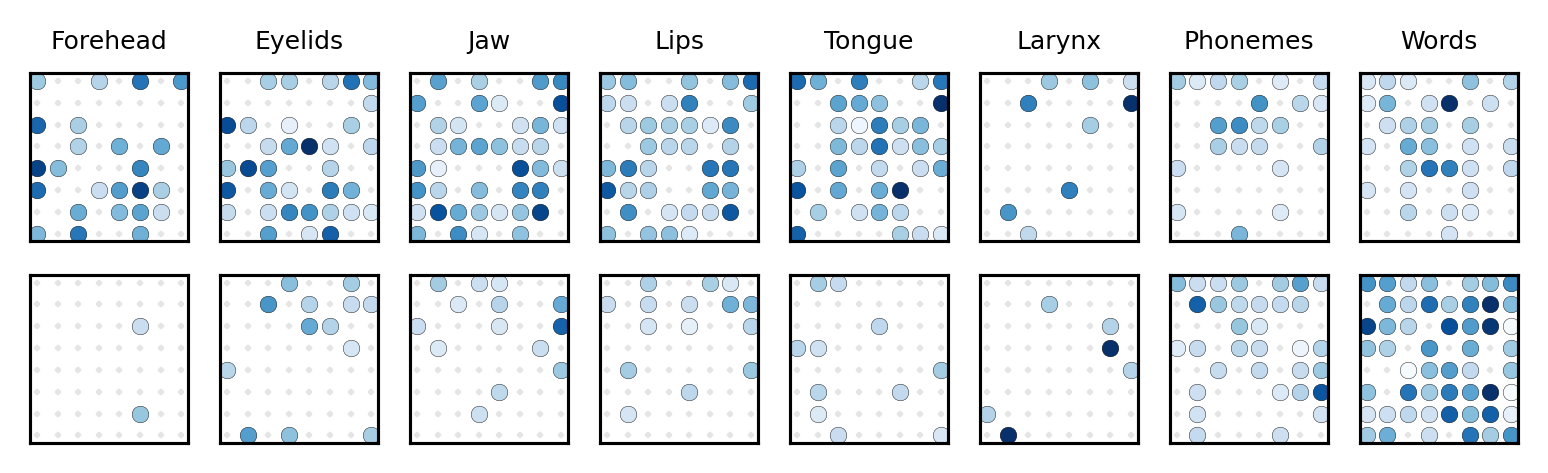

In [28]:
#quantify
oroCueSets = [[5,6,7,8],
              [9,10,11,12],
              [13,14,15,16,17,18],
              [23,24,25,26,27,28],
              [29,30,31,32,33],
              [19,20,21,22]]

phonemeSets = [[0,6,12,18,24,30]]
fiftyWordSets = [[1,8,16,24,32,40]]

tuningR2_oro, tuningPVal_oro = makeTuningHeatmap(orofacialDat, oroCueSets, [10,50])
tuningR2_phones, tuningPVal_phones = makeTuningHeatmap(phonemesDat, phonemeSets, [10,50])
tuningR2_fiftyWord, tuningPVal_fiftyWord = makeTuningHeatmap(fiftyWordDat, fiftyWordSets, [10,50])

tuningR2_all = np.concatenate([tuningR2_oro, tuningR2_phones, tuningR2_fiftyWord], axis=1)
tuningPVal_all = np.concatenate([tuningPVal_oro, tuningPVal_phones, tuningPVal_fiftyWord], axis=1)

heatmapPlotCircles(tuningR2_all[0:128,:],
            tuningPVal_all[0:128,:]<0.0001,
            [0,0.7],
            ['Forehead','Eyelids','Jaw','Lips','Tongue','Larynx','Phonemes','Words'],
            '6v')
plt.show()

The above plots indicate which neurons are tunned for a particular instruction cue (given in title), for the two electrode arrays in the brain area 6v. Shading indicates the fraction of variance accounted for (FVAF) by across-condition differences in mean firing rate.